# 기획 배경ㆍ최종목표

> 연금으로 생계 유지가 어려운 퇴직 후의 베이비붐 세대에 창업 열풍이 일어나고 있으며, 노령 세대에서 가장 많이 창업하는 업종은 한식당입니다.  
하지만 노령층의 폐업률이 142%에 달하고 있는 상황이 벌어지고 있어, **한식당 고객 리뷰** 데이터를 분석하기로 하였습니다.  
  
> 분석 내용을 바탕으로 한식당을 창업하기 전, 혹은 운영하며 지표로 참고할 수 있는 키워드를 제시하여 도움을 드리는 것이 주 목표입니다.

<img src="기획배경.png" width="40%"/>
<img src="기획배경2.png" width="40%"/>

<img src="최종목표.png" width="40%"/>

# 라이브러리/한글 설정

In [ ]:
### 필요 라이브러리/모듈 임포트
import pandas as pd
import re

%pip install nltk
%pip install wordcloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib import font_manager

In [ ]:
### 한글 깨짐 방지 위한 폰트 설정
import matplotlib.font_manager as fonm
font_list= [font.name for font in fonm.fontManager.ttflist]
for f in font_list:
    print(f"{f}.ttf")
# 설치된 한글 폰트로 설정
plt.rcParams['font.family'] = 'Hancom Gothic'

# 데이터 전처리

## 데이터 로드

In [106]:
df = pd.read_csv('kr3_data_category.csv', encoding='utf-8', index_col=0)
print('행열구조: ', df.shape)
print('-'*80)
df.head()

행열구조:  (54381, 4)
--------------------------------------------------------------------------------


,Rating,Review,length,review_spell_check
0,1,개인적으로 제일 좋아하는 냉면집진짜 집 근처였으면 일주일에 한번씩갈것같아요,41,개인적으로 제일 좋아하는 냉면집 진짜 집 근처였으면 일주일에 한 번씩 갈 것 같아요
1,1,방화동 구석의 정말 허름한 노포 아저씨의 응대가 유쾌하고 살갑다 손으로 쓴 메뉴판 ...,79,방화동 구석의 정말 허름한 노포 아저씨의 응대가 유쾌하고 살갑다 손으로 쓴 메뉴판 ...
2,1,아주머니 혼자하시는 식당이고 푸짐해요국물이 사골이라 맛있어요 순대는 쏘쏘해요,42,아주머니 혼자 하시는 식당이고 푸짐해요 국물이 사골이라 맛있어요 순대는 쏘쏘해요
3,1,장어가 담백하면서 고소하고 맛있습니다 비린맛이 적어 물리지 않고 맛있게 먹을 수 있어요,48,장어가 담백하면서 고소하고 맛있습니다 비린 맛이 적어 물리지 않고 맛있게 먹을 수 있어요
4,1,오픈 이벤트로 막국수 할인 중이며 맛있고 푸짐하여 가족 외식으로 괜찮은 곳,41,오픈 이벤트로 막국수 할인 중이며 맛있고 푸짐하여 가족 외식으로 괜찮은 곳


## 데이터 확인

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54381 entries, 0 to 61452
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Rating              54381 non-null  int64 
 1   Review              54368 non-null  object
 2   length              54381 non-null  int64 
 3   review_spell_check  54366 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.1+ MB


In [108]:
df.describe()

,Rating,length
count,54381.000000,54381.000000
mean,0.807874,65.608926
std,0.393975,49.773204
min,0.000000,0.000000
25%,1.000000,29.000000
50%,1.000000,50.000000
75%,1.000000,91.000000
max,1.000000,200.000000


## 결측치 제거

> 리뷰 분석하여 키워드 추출이 목적이므로 결측치가 있는 행은 제거합니다.

In [109]:
### 결측치 확인
df.isnull().sum()

Rating                 0
Review                13
length                 0
review_spell_check    15
dtype: int64

In [110]:
### 결측치 제거
df.dropna(inplace=True)  # 결측치 제거
df.reset_index(drop=True, inplace=True)  # 인덱스 재설정

# 결과 확인
df.isnull().sum()

Rating                0
Review                0
length                0
review_spell_check    0
dtype: int64

In [111]:
df.sample(10)

,Rating,Review,length,review_spell_check
4417,0,너무 맛없어요 김치찌개가 신맛이 너무 강해요,25,너무 맛없어요 김치찌개가 신맛이 너무 강해요
419,0,주전자에 들어있는 육수는 비린맛이 있고 냉면은 너무 짜요 한우 우린 육수라 짜서 뭐...,133,주전자에 들어있는 육수는 비린 맛이 있고 냉면은 너무 짜요 한우 우린 육수라 짜서 ...
17254,1,런치 A세트로 둘이 배부르게 잘 먹었습니닷 맛있는거에 맛있는거 쌈최고,38,런치 A 세트로 둘이 배부르게 잘 먹었습니다 맛있는 거에 맛있는 거 쌈최고
9921,0,좋았던 점 1 사람이 많이 없어 안전하게 먹는 느낌코로나 시국 2 넓은 공간 3 김...,181,좋았던 점 1 사람이 많이 없어 안전하게 먹는 느낌 코로나 시국 2 넓은 공간 3 ...
48212,1,소곱창 맛집입니다 초벌구이 한 것을 한번 더 익혀 먹는 시스템 곱창에 곱이 가득합니다,47,소 곱창 맛집입니다 초벌구이 한 것을 한 번 더 익혀 먹는 시스템 곱창에 곱이 가득합니다
29247,1,왔다네 또 왔다네 알고기 이날 사장님께서 수산시장 다녀오신 날이어서 한우성게소를 함...,162,왔다네 또 왔다네 알고 그 이날 사장님께서 수산시장 다녀오신 날이어서 한우 성게도를...
15930,0,정말 맛없다 질척거림 딱봐도 성의 없슴 오래된 집일뿐,29,정말 맛없다 질척거림 딱 봐도 성의 없음 오래된 집일뿐
29722,1,오늘은 신관에 포장하러 갔다가 보니 홀영업을 하길래 먹고왔다 고급진 진한 육수 다른...,96,오늘은 신관에 포장하러 갔다가 보니 올 영업을 하길래 먹고 왔다 고급 진 진한 육수...
49214,1,호텔에서 숙박하고 저녁에는 한려관이라는 한식집에서 먹었어요 음식도 깔끔하고 맛있었습니다,48,호텔에서 숙박하고 저녁에는 한 여관이라는 한식집에서 먹었어요 음식도 깔끔하고 맛있었습니다
42847,1,이집은 민어회도 좋지만 조림이 맛있어요 덕자조림과 병어조림 좋습니다 전라도 음식점,45,이 집은 민어회도 좋지만 조림이 맛있어요 덕자 조림과 병어조림 좋습니다 전라도 음식점


## 이모지, 특수문자, 개행문자 제거

> 역시 키워드 추출이 주 목적이므로 특수문자, 이모지, 개행 문자는 제거합니다.

In [112]:
# 이모지와 특수문자 여부 검사 및 제거를 위한 정규화
import re

# 정규식 패턴으로 이모지와 특수문자를 검색하는 패턴
pattern = r'[^\w\sㄱ-ㅣ가-힣]+'

# 이모지와 특수문자가 있는 행 추출
emoji_special_chars_rows = df[(df['Review'].str.contains(pattern)) | (df['review_spell_check'].str.contains(pattern))]

# 추출된 행 출력
display(emoji_special_chars_rows)

# 정규식 패턴으로 이모지와 특수문자 여부 재검색
display(df['Review'].str.contains(pattern))

print('='*80)

df.info()

,Rating,Review,length,review_spell_check
34,1,의왕역 냉면집비빔냉면 ★★★★☆김치콩나물국밥 ★★☆☆☆ 의왕역 근처 음식점 냉면은 ...,106,의왕역 냉면집 비빔냉면 ★★★★☆김치 콩나물국밥 ★★☆☆☆ 의왕역 근처 음식점 냉면...
97,1,너무 맛있는 돼지갈비 고깃집입니다 맛도 맛인데 가격도 착합니다 비냉보다 물냉맛이 시...,104,너무 맛있는 돼지갈비 고깃집입니다 맛도 맛인데 가격도 착합니다 비냉보다 물랭 맛이 ...
151,1,발 욕나오게 맛있음 중독됨 또 가고싶음 단점 사람이 ♪♩♬게 많다,38,발 욕 나오게 맛있음 중독됨 또 가고 싶음 단점 사람이 ♪♩♬게 많다
153,0,진짜 싸가지 없어서 그냥 들어가자마자 나왔어요 서비스 죽이네요 가지마세요 ♪♩♪♪임,47,진짜 싹수없어서 그냥 들어가자마자 나왔어요 서비스 죽이네요 가지 마세요 ♪♩♪♪임
188,1,나오자마자 정신없이먹느라 냉면사진을 깜빡할 정도로 맛나요맛나♡ 만두꼭시켜드십시오들♡,46,나오자마자 정신없이 먹느라 냉면 사진을 깜빡할 정도로 맛나요 맛나♡ 만두 꼭 시켜 ...
...,...,...,...,...
54050,1,떡볶이 덕후로서 신전은 사랑입니다 둘이서 만원정도면 진짜 맛있는 떡볶이와 튀김 그리...,144,떡볶이 덕후로서 신전은 사랑입니다 둘이서 만 원 정도면 진짜 맛있는 떡볶이와 튀김 ...
54051,1,점심에 종종 혼밥하는 터포키 중독자입니당 엽떡도 맛있지만 신전도 신전만의 맛이 있지...,192,점심에 종종 혼밥 하는 터 포키 중독자입니다 엽떡도 맛있지만 신전도 신전만의 맛이 ...
54079,1,친절하고 이 동네에서 가장 오래된집 맛있어요 ♡♡♡♡♡,30,친절하고 이 동네에서 가장 오래된 집 맛있어요 ♡♡♡♡♡
54328,1,맛있어서 다 먹었더니 뻥튀기를 주시더군여이득★ 그리고 원래 연근 안좋아하는편인데 여...,97,맛있어서 다 먹었더니 뻥튀기를 주시더군요 이득★ 그리고 원래 연근 안 좋아하는 편인...


0        False
1        False
2        False
3        False
4        False
         ...  
54361    False
54362    False
54363    False
54364    False
54365    False
Name: Review, Length: 54366, dtype: bool

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54366 entries, 0 to 54365
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Rating              54366 non-null  int64 
 1   Review              54366 non-null  object
 2   length              54366 non-null  int64 
 3   review_spell_check  54366 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.7+ MB


In [113]:
# 이모지 및 특수문자 제거
import re

def remove_special_characters(text):
    pattern = r'[^\w\sㄱ-ㅣ가-힣]'  # 특수문자나 이모지 패턴
    clean_text = re.sub(pattern, '', text)
    return clean_text

# 전처리한 컬럼 생성
df['clean_Review'] = df['Review'].apply(remove_special_characters)

# 전처리 후 맞춤법 검사 컬럼 생성
df['clean_review_spell_check'] = df['review_spell_check'].apply(remove_special_characters)

# 결과 확인
df.head(3)

,Rating,Review,length,review_spell_check,clean_Review,clean_review_spell_check
0,1,개인적으로 제일 좋아하는 냉면집진짜 집 근처였으면 일주일에 한번씩갈것같아요,41,개인적으로 제일 좋아하는 냉면집 진짜 집 근처였으면 일주일에 한 번씩 갈 것 같아요,개인적으로 제일 좋아하는 냉면집진짜 집 근처였으면 일주일에 한번씩갈것같아요,개인적으로 제일 좋아하는 냉면집 진짜 집 근처였으면 일주일에 한 번씩 갈 것 같아요
1,1,방화동 구석의 정말 허름한 노포 아저씨의 응대가 유쾌하고 살갑다 손으로 쓴 메뉴판 ...,79,방화동 구석의 정말 허름한 노포 아저씨의 응대가 유쾌하고 살갑다 손으로 쓴 메뉴판 ...,방화동 구석의 정말 허름한 노포 아저씨의 응대가 유쾌하고 살갑다 손으로 쓴 메뉴판 ...,방화동 구석의 정말 허름한 노포 아저씨의 응대가 유쾌하고 살갑다 손으로 쓴 메뉴판 ...
2,1,아주머니 혼자하시는 식당이고 푸짐해요국물이 사골이라 맛있어요 순대는 쏘쏘해요,42,아주머니 혼자 하시는 식당이고 푸짐해요 국물이 사골이라 맛있어요 순대는 쏘쏘해요,아주머니 혼자하시는 식당이고 푸짐해요국물이 사골이라 맛있어요 순대는 쏘쏘해요,아주머니 혼자 하시는 식당이고 푸짐해요 국물이 사골이라 맛있어요 순대는 쏘쏘해요


In [114]:
# 이모지와 특수문자가 있는 행 추출
emoji_special_chars_rows = df[
    (df['clean_Review'].str.contains(pattern)) | (df['clean_review_spell_check'].str.contains(pattern))]

# 추출된 행 출력
print(emoji_special_chars_rows)

Empty DataFrame
Columns: [Rating, Review, length, review_spell_check, clean_Review, clean_review_spell_check]
Index: []


In [115]:
### 불필요한 열 제거
# 제거할 열의 리스트
df = df.drop(['length', 'Review', 'review_spell_check'], axis=1)

# 결과 확인
df

,Rating,clean_Review,clean_review_spell_check
0,1,개인적으로 제일 좋아하는 냉면집진짜 집 근처였으면 일주일에 한번씩갈것같아요,개인적으로 제일 좋아하는 냉면집 진짜 집 근처였으면 일주일에 한 번씩 갈 것 같아요
1,1,방화동 구석의 정말 허름한 노포 아저씨의 응대가 유쾌하고 살갑다 손으로 쓴 메뉴판 ...,방화동 구석의 정말 허름한 노포 아저씨의 응대가 유쾌하고 살갑다 손으로 쓴 메뉴판 ...
2,1,아주머니 혼자하시는 식당이고 푸짐해요국물이 사골이라 맛있어요 순대는 쏘쏘해요,아주머니 혼자 하시는 식당이고 푸짐해요 국물이 사골이라 맛있어요 순대는 쏘쏘해요
3,1,장어가 담백하면서 고소하고 맛있습니다 비린맛이 적어 물리지 않고 맛있게 먹을 수 있어요,장어가 담백하면서 고소하고 맛있습니다 비린 맛이 적어 물리지 않고 맛있게 먹을 수 있어요
4,1,오픈 이벤트로 막국수 할인 중이며 맛있고 푸짐하여 가족 외식으로 괜찮은 곳,오픈 이벤트로 막국수 할인 중이며 맛있고 푸짐하여 가족 외식으로 괜찮은 곳
...,...,...,...
54361,1,자연밥상세트중에 마누라밥상 먹었어요 이거 많이 드시는거같던데 바싹소불고기랑 고등어구...,자연밥상 세트 중에 마누라 밥상 먹었어요 이거 많이 드시는 거 같던데 바싹 소 불고...
54362,1,한상차림으로 똭 나오고 거기에 다른 필요한 쌈류나 반찬들 눈치안보고 편하게 셀바에서...,한상차림으로 똭 나오고 거기에 다른 필요한 쌈류나 반찬들 눈치 안 보고 편하게 셀바...
54363,1,여기 정말 진짜 맛있음 마지막에 넣는 마늘이 더해져 느끼하지 않은 국물 햄 종류도 ...,여기 정말 진짜 맛있음 마지막에 넣는 마늘이 더해져 느끼하지 않은 국물 햄 종류도 ...
54364,1,가격대비 괜찮긴한데 가격을 자꾸 올리고 샐러드바 메뉴는 줄어드는 경향이 있어서 살짝...,가격 대비 괜찮긴 한데 가격을 자꾸 올리고 샐러드바 메뉴는 줄어드는 경향이 있어서 ...


# 긍정ㆍ부정 리뷰 추출

In [116]:
df.Rating.value_counts()

Rating
1    43919
0    10447
Name: count, dtype: int64

In [117]:
# 긍정 컬럼과 부정 컬럼의 행 수를 확인
positive_rows = 43919
negative_rows = 10447

# 긍정 컬럼에서 1만개의 랜덤 샘플 추출
positive_sample = df[df['Rating']==1].sample(n=10000, random_state=13)

# 부정 컬럼에서 1만개의 랜덤 샘플 추출
negative_sample = df[df['Rating']==0].sample(n=10000, random_state=13)

# 추출된 샘플을 결합
balanced_df = pd.concat([positive_sample, negative_sample])

# 행을 무작위로 섞음
balanced_df = balanced_df.sample(frac=1, random_state=13).reset_index(drop=True)
rating_check = balanced_df['Rating'].unique()
print(rating_check)

# 결과 확인
print(balanced_df['Rating'].value_counts())

[0 1]
Rating
0    10000
1    10000
Name: count, dtype: int64


In [118]:
## 결과 확인
balanced_df

,Rating,clean_Review,clean_review_spell_check
0,0,가격대비 제일싼거만 그냥저냥 괜찬고 30000원이상 왜 여기서 먹는지 시끄럽고 별루...,가격 대비 제일 싼 거만 그냥저냥 괜찮고 30000원 이상 왜 여기서 먹는지 시끄럽...
1,0,3월 20일에 이곳을 방문하여 3만원짜리 정식을 4인 주문했습니다 2만원짜리는 조기...,3월 20일에 이곳을 방문하여 3만 원짜리 정식을 4인 주문했습니다 2만 원짜리는 ...
2,0,눈이맵고 기침많이나고 그것들을참으면서 먹기는좀 힘들더라구요,눈이 맵고 기침 많이 나고 그것들을 참으면서 먹기는 좀 힘들더라고요
3,1,비싸도 맛있어요 삼청동에가면 꼭 한번 들려야하는곳이에요,비싸도 맛있어요 삼청동에 가면 꼭 한번 들려야 하는 곳이에요
4,1,자욱한 연기에 뭘 먹었는지 기억이 안나던 시절 부터 다녔던 집 고추장이면 간장이며 ...,자욱한 연기에 뭘 먹었는지 기억이 안 나던 시절부터 다녔던 집 고추장이면 간장이며 ...
...,...,...,...
19995,1,기본으로 주시는 오렌지소스가 오렌지 맛이 그대로 느껴지는 상큼한 맛이에요 정말 맛있어요,기본으로 주시는 오렌지 소스가 오렌지 맛이 그대로 느껴지는 상큼한 맛이에요 정말 맛있어요
19996,1,고기 최고 짱짱 충성충성충성,고기 최고 짱짱 충성 충성 충성
19997,1,너무 맛있고 좋았어요 저렴한 가격에 맛있게 잘먹었습니다,너무 맛있고 좋았어요 저렴한 가격에 맛있게 잘 먹었습니다
19998,0,유명한 집이길래 가본곳고기는 질기고 달다냉면은 마트에서 파는 냉면 사서 쓰는듯한맛파...,유명한 집이길래 가 본 곳이 고기는 질기고 달다 냉면은 마트에서 파는 냉면 사서 쓰...


In [119]:
# Rating 컬럼 제거
df = balanced_df.drop(['Rating'], axis=1)
df.head(2)

,clean_Review,clean_review_spell_check
0,가격대비 제일싼거만 그냥저냥 괜찬고 30000원이상 왜 여기서 먹는지 시끄럽고 별루...,가격 대비 제일 싼 거만 그냥저냥 괜찮고 30000원 이상 왜 여기서 먹는지 시끄럽...
1,3월 20일에 이곳을 방문하여 3만원짜리 정식을 4인 주문했습니다 2만원짜리는 조기...,3월 20일에 이곳을 방문하여 3만 원짜리 정식을 4인 주문했습니다 2만 원짜리는 ...


In [120]:
# 열 이름 변경
df = df.rename(columns={'clean_Review': 'Review', 'clean_review_spell_check': 'review_spell_check'})
df.head(5)

,Review,review_spell_check
0,가격대비 제일싼거만 그냥저냥 괜찬고 30000원이상 왜 여기서 먹는지 시끄럽고 별루...,가격 대비 제일 싼 거만 그냥저냥 괜찮고 30000원 이상 왜 여기서 먹는지 시끄럽...
1,3월 20일에 이곳을 방문하여 3만원짜리 정식을 4인 주문했습니다 2만원짜리는 조기...,3월 20일에 이곳을 방문하여 3만 원짜리 정식을 4인 주문했습니다 2만 원짜리는 ...
2,눈이맵고 기침많이나고 그것들을참으면서 먹기는좀 힘들더라구요,눈이 맵고 기침 많이 나고 그것들을 참으면서 먹기는 좀 힘들더라고요
3,비싸도 맛있어요 삼청동에가면 꼭 한번 들려야하는곳이에요,비싸도 맛있어요 삼청동에 가면 꼭 한번 들려야 하는 곳이에요
4,자욱한 연기에 뭘 먹었는지 기억이 안나던 시절 부터 다녔던 집 고추장이면 간장이며 ...,자욱한 연기에 뭘 먹었는지 기억이 안 나던 시절부터 다녔던 집 고추장이면 간장이며 ...


In [121]:
# 키워드별 횟수 세는 함수
def preprocess(data):
  my_split = []
  for pas in data.iloc:
    data = (pas['review_spell_check'])
    split_data = data.split(' ')
    for i in split_data:
      if len(i) >= 2:
        my_split.append(i)
  return my_split


# 개수 확인
pre_data = preprocess(df)
print(Counter(pre_data[:200]))

Counter({'3만': 3, '원짜리는': 3, '있는': 3, '2만': 2, '마리': 2, '많이': 2, '않는': 2, '맛있다': 2, '맛있는': 2, '비계의': 2, '비율이': 2, '건지': 2, '황등': 2, '메뉴판에': 2, '가격을': 2, '가격': 1, '대비': 1, '제일': 1, '거만': 1, '그냥저냥': 1, '괜찮고': 1, '30000원': 1, '이상': 1, '여기서': 1, '먹는지': 1, '시끄럽고': 1, '별로': 1, '가성비': 1, '없음': 1, '3월': 1, '20일에': 1, '이곳을': 1, '방문하여': 1, '원짜리': 1, '정식을': 1, '4인': 1, '주문했습니다': 1, '조기가': 1, '1인에': 1, '5천': 1, '1인당': 1, '떡갈비': 1, '추가가': 1, '된다고': 1, '하여': 1, '원짜리로': 1, '주문을': 1, '하였습니다': 1, '먹고': 1, '나서': 1, '오늘': 1, '하루': 1, '종일': 1, '기분이': 1, '정말': 1, '더러워서': 1, '참을': 1, '수가': 1, '없습니다': 1, '맛이': 1, '있고': 1, '없는': 1, '기준이': 1, '사람마다': 1, '모두': 1, '다르겠지만': 1, '기준에서': 1, '봤을': 1, '의견으로는': 1, '눈이': 1, '맵고': 1, '기침': 1, '나고': 1, '그것들을': 1, '참으면서': 1, '먹기는': 1, '힘들더라고요': 1, '비싸도': 1, '맛있어요': 1, '삼청동에': 1, '가면': 1, '한번': 1, '들려야': 1, '하는': 1, '곳이에요': 1, '자욱한': 1, '연기에': 1, '먹었는지': 1, '기억이': 1, '나던': 1, '시절부터': 1, '다녔던': 1, '고추장이면': 1, '간장이며': 1, '한결같은': 1, '고추까지도': 1, '오랜': 1, '세월에도': 1, '변하지': 1, '그

In [122]:
# 컬럼 생성성
df['맛있어요'] = 0
df['친절'] = 0
df['깔끔'] = 0
df['최고'] = 0
df['가성비'] = 0

df['맛없어요'] = 0
df['불친절'] = 0
df['최악'] = 0
df['별로'] = 0
df['다신'] = 0

# 긍정 키워드 정리
positive_list = ['맛있지는', '감칠맛있게', '맛있는진', '아주맛있지도', '맛있는녀석들', '맛있는녀석들', '맛있는녀석들도', '애매한맛뭐가맛있는건지', '맛있는지는', 
                 '맛있다는건지',  '맛있는건가', '감칠맛있고', '맛있을줄', '맛있는맛은', '맛있을텐데', '맛있을겁니다', '맛있던곳인데', '맛있다는건가', '맛있지는', 
                 '안맛있는게', '맛있다고해서', '맛있어서웨이팅길겠거니그냥고', '맛있다고하길래', '맛있는거였나', '맛있다하기엔',  '맛있으려나',  '맛있냐',  '맛있었던건지', 
                 '맛있어지는때라겨울엔', '맛있었음근데지금은', '그닥맛있게', '맛있어봤자얼마나', '맛있다는건아니고김밥빼고', '맛있어야하는데밥이질다두번이용은', 
                 '작년5월에댕겨왔는데진짜의문인곳뭐가맛있다는건지', '더맛있는곳가세요', '맛있다기보단', '맛있었는데요즘은', '맛있었는데', '맛있진않다떡볶이는', 
                 '맛있음httpmblognavercomPostViewnhnblogIdyujini0310logNo220402717533', '맛있진않아도', '여기왜맛있다는건지다들', '맛있었는데쫄면은', '하러가고싶은맛맛있게먹은사람이', 
                 '맛있을리가', '밍밍맛있다고', '오이소박이추가주문까지시켜먹었는데그맛있는그집이아니었습니다너무달아요', '맛있을거라하던데', '맛있게짠게아니였네요', '안맛있음', '맛있다고해서', 
                 '맛있진않아도', '맛있는진', '맛있는걸까요', '그렇게맛있다는데', '별로인데맛있었다는', '맛있다더니', '너무달다매운맛도달다육회초밥이나불고기초밥은맛있게', '맛있어야하는데', '맛있는걸까효', 
                 '맛있다기', '맛있다기보다', '맛있다는건', '머가맛있다는건지', '맛있지는', '맛있는데가더많은데', '맛있는대가', '시간버리지마셔요맛있으면', '왜맛있다는지', 
                 '완전불친절맛있다고해도입맛사라지는들어갔다기분상하고나옴', '주시는데맛있진', '맛있지는', '맛있진않지만', '맛있진', '맛있지도', '맛있었던가', '딱히맛있는건없고재료는', '맛있지도', 
                 '엄청맛있지는', '오이소박이추가주문까지시켜먹었는데그맛있는그집이아니었습니다너무달아요',  '김치가맛있어야하는데', '엄청맛있다할정돈', '엄청맛있다할정돈', '안맛있음', '맛있는줄', 
                 '맛있는거였나', '맛있지도', '미원냄새는왜케나는지이영자아무데나맛있다고하나보네', '맛있을까요', '그렇게맛있는정도는아니다반찬이', '맛있지도', '결코맛있지도않은수준',  '맛있진않아요', 
                 '가격대비맛있는지','맛있을듯', '맛있대요', '맛있을거', '맛있다고', '줬으면맛있음', '맛있다기보단', '맛있었어요아이가', '맛있을', '맛있지도', '맛있을것같아', '맛있다란', '맛있으면', 
                 '맛있을까하고', '미원냄새는왜케나는지이영자아무데나맛있다고하나보네', '맛있기도', '맛있을', '맛있는건', '그렇게맛있는정도는아니다반찬이', '맛있을수가없어요', '맛있는것도', '맛있겠냐만은', 
                 '결코맛있지도않은수준', '맛있어서라기보단', '맛있던먹을때는']

exclusion_patterns1 = [word for word in positive_list]

exclusion_regex1 = '|'.join(exclusion_patterns1)
print(exclusion_regex1)

맛있지는|감칠맛있게|맛있는진|아주맛있지도|맛있는녀석들|맛있는녀석들|맛있는녀석들도|애매한맛뭐가맛있는건지|맛있는지는|맛있다는건지|맛있는건가|감칠맛있고|맛있을줄|맛있는맛은|맛있을텐데|맛있을겁니다|맛있던곳인데|맛있다는건가|맛있지는|안맛있는게|맛있다고해서|맛있어서웨이팅길겠거니그냥고|맛있다고하길래|맛있는거였나|맛있다하기엔|맛있으려나|맛있냐|맛있었던건지|맛있어지는때라겨울엔|맛있었음근데지금은|그닥맛있게|맛있어봤자얼마나|맛있다는건아니고김밥빼고|맛있어야하는데밥이질다두번이용은|작년5월에댕겨왔는데진짜의문인곳뭐가맛있다는건지|더맛있는곳가세요|맛있다기보단|맛있었는데요즘은|맛있었는데|맛있진않다떡볶이는|맛있음httpmblognavercomPostViewnhnblogIdyujini0310logNo220402717533|맛있진않아도|여기왜맛있다는건지다들|맛있었는데쫄면은|하러가고싶은맛맛있게먹은사람이|맛있을리가|밍밍맛있다고|오이소박이추가주문까지시켜먹었는데그맛있는그집이아니었습니다너무달아요|맛있을거라하던데|맛있게짠게아니였네요|안맛있음|맛있다고해서|맛있진않아도|맛있는진|맛있는걸까요|그렇게맛있다는데|별로인데맛있었다는|맛있다더니|너무달다매운맛도달다육회초밥이나불고기초밥은맛있게|맛있어야하는데|맛있는걸까효|맛있다기|맛있다기보다|맛있다는건|머가맛있다는건지|맛있지는|맛있는데가더많은데|맛있는대가|시간버리지마셔요맛있으면|왜맛있다는지|완전불친절맛있다고해도입맛사라지는들어갔다기분상하고나옴|주시는데맛있진|맛있지는|맛있진않지만|맛있진|맛있지도|맛있었던가|딱히맛있는건없고재료는|맛있지도|엄청맛있지는|오이소박이추가주문까지시켜먹었는데그맛있는그집이아니었습니다너무달아요|김치가맛있어야하는데|엄청맛있다할정돈|엄청맛있다할정돈|안맛있음|맛있는줄|맛있는거였나|맛있지도|미원냄새는왜케나는지이영자아무데나맛있다고하나보네|맛있을까요|그렇게맛있는정도는아니다반찬이|맛있지도|결코맛있지도않은수준|맛있진않아요|가격대비맛있는지|맛있을듯|맛있대요|맛있을거|맛있다고|줬으면맛있음|맛있다기보단|맛있었어요아이가|맛있을|맛있지도|맛있을것같아|맛있다란|맛있으면|맛있을까하고|미원

In [123]:
# 부정 키워드 정리
negative_del_list = ['누가맛없데', '누가맛없데', '맛없는게없어요', '입맛없었는데', '아주맛없냐하면', '맛없어짐살은', '맛없다고하면', '맛없다는', '맛없을수가', '맛없는', '맛없지도', '맛없는', '맛없기로', 
                     '맛없는게없더라구요', '입맛없을', '입맛없을', '입맛없을때가면', '맛없다고', '백숙맛없을줄알았는데', '입맛없을때', '맛없다고는', '입맛없을때', '깊은맛없음', '입맛없을때', '매운맛없이', 
                     '맛없을거같았는데', '단맛없는', '맛없을수가없지', '맛없진않은데', '조미료맛없이', '비린맛없는', '맛없는건아닌데', '맛없는게없네요', '조미료맛없이', '맛없어서']

exclusion_patterns2 = [word for word in negative_del_list]

exclusion_regex2 = '|'.join(exclusion_patterns2)
print(exclusion_regex2)

누가맛없데|누가맛없데|맛없는게없어요|입맛없었는데|아주맛없냐하면|맛없어짐살은|맛없다고하면|맛없다는|맛없을수가|맛없는|맛없지도|맛없는|맛없기로|맛없는게없더라구요|입맛없을|입맛없을|입맛없을때가면|맛없다고|백숙맛없을줄알았는데|입맛없을때|맛없다고는|입맛없을때|깊은맛없음|입맛없을때|매운맛없이|맛없을거같았는데|단맛없는|맛없을수가없지|맛없진않은데|조미료맛없이|비린맛없는|맛없는건아닌데|맛없는게없네요|조미료맛없이|맛없어서


In [154]:
df.loc[df['review_spell_check'].str.contains('맛있', na=False) & ~df['review_spell_check'].str.contains(exclusion_regex1, na=False),'맛있어요'] = 1
df.loc[df['review_spell_check'].str.contains('친절', na=False) & ~df['review_spell_check'].str.contains('불친절', na=False),'친절'] = 1
df.loc[df['review_spell_check'].str.contains('깔끔', na=False), '깔끔'] = 1
df.loc[df['review_spell_check'].str.contains('최고', na=False), '최고'] = 1
df.loc[df['review_spell_check'].str.contains('가성비', na=False), '가성비'] = 2
df.loc[df['review_spell_check'].str.contains('맛없', na=False) & ~df['review_spell_check'].str.contains(exclusion_regex2, na=False),'맛없어요'] = 1
df.loc[df['review_spell_check'].str.contains('불친절', na=False),'불친절'] = 1
df.loc[df['review_spell_check'].str.contains('최악', na=False), '최악'] = 1
df.loc[df['review_spell_check'].str.contains('별로', na=False), '별로'] = 1
df.loc[df['review_spell_check'].str.contains('다신', na=False) | df['review_spell_check'].str.contains('다시는', na=False), '다신'] = 1

"""
###### 가성비가 높다는 걸 가중치 높게 설정했으나, 처리하고 보니 리뷰에서 가성비라는 단어는 긍정. 부정 모두에게 작용해서 합산에서 제외하기로 결정
"""

df['pos_total'] = df[['맛있어요', '친절', '깔끔', '최고']].sum(axis=1)
df['neg_total'] = df[['맛없어요', '불친절', '최악', '별로', '다신']].sum(axis=1)

# 결과 확인
df.sample(3)

,Review,review_spell_check,맛있어요,친절,깔끔,최고,가성비,맛없어요,불친절,최악,별로,다신,pos_total,neg_total
8052,괜찮은 한정식집입니다 가족끼리나 괜찮은 한끼한식식사로는 제격이에요 간이세지않아서 만...,괜찮은 한정식집입니다 가족끼리나 괜찮은 한 끼 한식 식사로는 제격이에요 간이 세지 ...,0,0,0,0,0,0,0,0,0,0,0,0
15327,설렁탕 국물맛도 그저 그렇고 반찬도 뭐 특별히 가야 될 이유는 없어 보임,설렁탕 국물 맛도 그저 그렇고 반찬도 뭐 특별히 가야 될 이유는 없어 보임,0,0,0,0,0,0,0,0,0,0,0,0
13396,아 진짜 노맛이네 가격도 다른 냉면보다 비싼데,아 진짜 놈 맛이네 가격도 다른 냉면보다 비싼데,0,0,0,0,0,0,0,0,0,0,0,0


In [153]:
df[df['가성비'] != 0]

,Review,review_spell_check,맛있어요,친절,깔끔,최고,가성비,맛없어요,불친절,최악,별로,다신,pos_total,neg_total
0,가격대비 제일싼거만 그냥저냥 괜찬고 30000원이상 왜 여기서 먹는지 시끄럽고 별루...,가격 대비 제일 싼 거만 그냥저냥 괜찮고 30000원 이상 왜 여기서 먹는지 시끄럽...,0,0,0,0,2,0,0,0,1,0,0,1
187,16년까지만해도 안암역 고려대 참살이길의 분식왕은 고른햇살이었다 다만 요즘은 17년...,16년까지만 해도 안암역 고려대 참살이 길의 분식 왕은 고른 햇살이었다 다만 요즘은...,0,0,0,0,2,0,0,0,0,0,0,0
188,1음식가성비 전체적인 평가는 5점10점만점으로 가격은 5천원 정도가 적당해보임 고기...,1음식 가성비 전체적인 평가는 5점 10점 만점으로 가격은 5천 원 정도가 적당해 ...,0,1,0,0,2,0,0,0,0,0,1,0
228,가성비 최고 음식을 다먹지 못하고 남기고 나오는 집 최소 한시간 이전 예약 필수,가성비 최고 음식을 다 먹지 못하고 남기고 나오는 집 최소 한 시간 이전 예약 필수,0,0,0,1,2,0,0,0,0,0,1,0
234,가성비도 안 좋지만 일단 맛자체도 많이 떨어집니다,가성비도 안 좋지만 일단 맛 자체도 많이 떨어집니다,0,0,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19504,맛은 있는데 가성비가 조금 그리고 여러명인데 1세트씩 시키지 못하고 세트인데도 메뉴...,맛은 있는데 가성비가 조금 그리고 여러 명인데 1세트씩 시키지 못하고 세트인데도 메...,0,0,0,0,2,0,0,0,0,0,0,0
19620,리뉴얼 된 이후 전혀 가고 싶지 않은 곳이 되었습니다공복의 매력은 1 양념된 고기가...,리뉴얼 된 이후 전혀 가고 싶지 않은 곳이 되었습니다 공복의 매력은 1 양념된 고기...,1,0,0,0,2,0,0,0,0,0,1,0
19739,가성비 안좋고 단체 예약했는데 자리를 너무 좁은데로 줘서 그릇을 둘곳도 없이 불편하...,가성비 안 좋고 단체 예약했는데 자리를 너무 좁은 데로 줘서 그릇을 둘 곳도 없이 ...,0,0,0,0,2,0,0,0,0,1,0,1
19888,댓글 잘 안다는데 맛있다는 글이 너무 많아서 올립니다 맛이 있긴했지만 이 가격을 주...,댓글 잘 안다는데 맛있다는 글이 너무 많아서 올립니다 맛이 있긴 했지만 이 가격을 ...,1,0,1,1,2,0,0,0,0,0,3,0


# 시각화 - 키워드 추출

## 위생 부문의 주요 키워드 선정

In [126]:
# 위생 부문(1)
clean = ['담배', '먼지', '벌레','깔끔', '청결', '환기', '머리카락']
clean = '|'.join(clean)
df_clean = df.loc[df['review_spell_check'].str.contains(clean, na=False)].drop(['Review','맛있어요', '친절', '깔끔', '최고', '가성비', 
                                                                                '맛없어요', '불친절','최악','별로','다신','pos_total','neg_total'], axis=1)
df_clean

,review_spell_check
28,분위가 도 좋고 상차림도 깔끔하며 직원들도 친절하고 모든 음식이 골고루...
90,발레 강제 2천 원 냉면 11000원인데 면은 뭉쳐나오고 값어치는 안되는 듯 맛은 ...
115,여기 음식이 깔끔하고 맛이 좋았어요 가평 놀러 가서 신나게 물놀이하고 좀 늦은 점심...
124,음식이 깔끔하니 맛있어서 식사 대접하기도 좋은 곳 같아요
146,i found hair and I claimed but owner has haven...
...,...
19946,추천받아 갔는데 진짜 너무 맛있어요 가게도 깔끔해서 좋았고요 음식이 너무 신선합니다...
19954,점심으로 보리밥 먹었는데 맛은 있는데 밥에 고춧가루 묻어서 나온 거까진 이해했는데 ...
19955,여자 혼자 여행 중 진짜 배고파 죽을뻔했는데 다 2인분씩 주문이던지 사장님 장 보...
19958,부모님 모시고 다녀왔는데 음식도 깔끔하게 나오고 직원분들도 친절하게 해주셔서 덕분에...


In [127]:
# 위생 부문(2)
# '담배', '먼지', '벌레', '쓰레기'
clean = []
for my_data in df_clean.iloc:
    data = (my_data['review_spell_check']).split(' ')
    for i in data:
      if '담배' in i and len(i) == 2:
        clean.append(i)
      elif '먼지' in i and len(i) == 2:
        clean.append(i)
      elif '벌레' in i and len(i) == 2:
        clean.append(i)
      elif '깔끔' in i and len(i) == 2:
        clean.append(i)
      elif '청결' in i and len(i) == 2:
        clean.append(i)
      elif '환기' in i and len(i) == 2:
        clean.append(i)
      elif '머리카락' in i and len(i) == 4:
        clean.append(i)

print(pd.Series(data=clean).value_counts())

머리카락    34
담배      28
깔끔      28
청결      21
벌레      19
먼지      15
환기      10
Name: count, dtype: int64


## 서비스 부문의 주요 키워드 선정

In [128]:
# 서비스 부문(1)
service = ['컴플레인', '서빙', '예약', '친절', '리필']
service = '|'.join(service)
df_service = df.loc[df['review_spell_check'].str.contains(service,  na=False)].drop(['Review','맛있어요', '친절', '깔끔', '최고', '가성비', '맛없어요', '불친절','최악','별로','다신','pos_total','neg_total'], axis=1)
df_service

,review_spell_check
10,평양 마니아로써 이곳은 최악 면에서는 밀가루 냄새가 너무 많이 남 메일의 함량이 메...
28,분위가 도 좋고 상차림도 깔끔하며 직원들도 친절하고 모든 음식이 골고루...
36,사장님도 친절하시고 고기도 맛있고 된장찌개까지 끝내줌
43,싸지 않고 친절하지 않고 양이 적고 간이 강하다 한식이 반찬이 절반 이상이라 생각하...
46,며칠 전 부모님 모시고 5명이 갔는데 사람은 많다 23명 앉았는데 한상만 반찬 줘서...
...,...
19958,부모님 모시고 다녀왔는데 음식도 깔끔하게 나오고 직원분들도 친절하게 해주셔서 덕분에...
19963,세상 불친절한 곳 카운터 할머니 사장님도 불친절 서빙 아주머니들도 불친절 맛은 보통
19968,진짜 살면서 본 식당 중에 젤 불친절 인원 수보다 1인분이라도 적게 시키면 바로 째...
19973,직원 사장님 전부 친절하고 일단 고기가 맛있어요 제가 간 날은 껍데기 서비스도 주셨...


In [129]:
# 서비스 부문(2)
service = []
for my_data in df_service.iloc:
    data = (my_data['review_spell_check']).split(' ')
    for i in data:
      if '컴플레인' in i and len(i) == 4:
        service.append(i)
      elif '클레임' in i and len(i) == 3:
        service.append(i)
      elif '서빙' in i and len(i) == 2:
        service.append(i)
      elif '예약' in i and len(i) == 2:
        service.append(i)
      elif '친절' in i and len(i) == 2:
        service.append(i)
      elif '리필' in i and len(i) == 2:
        service.append(i)
print(pd.Series(data=service).value_counts())

예약      134
서빙       95
친절       71
리필       48
컴플레인     24
클레임       2
Name: count, dtype: int64


## 음식 부문의 주요 키워드 선정

In [130]:
# 음식 부문(1)
# 키워드. 맛, 양, 입맛, 반찬

food = ['맛', '양', '입맛', '반찬', '후식', '디저트']
food = '|'.join(food)
df_food = df.loc[df['review_spell_check'].str.contains(food,  na=False)].drop(['Review','맛있어요', '친절', '깔끔', '최고', '가성비', '맛없어요', '불친절','최악','별로','다신','pos_total','neg_total'], axis=1)
df_food

,review_spell_check
1,3월 20일에 이곳을 방문하여 3만 원짜리 정식을 4인 주문했습니다 2만 원짜리는 ...
3,비싸도 맛있어요 삼청동에 가면 꼭 한번 들려야 하는 곳이에요
4,자욱한 연기에 뭘 먹었는지 기억이 안 나던 시절부터 다녔던 집 고추장이면 간장이며 ...
5,고기의 복불복이 좀 있는 편이고 기는 항상 맛있는데 비계의 비율이 좀 많아서 다른 ...
6,중독성 있는 맛 떡볶이가 당길 때 생각나요
...,...
19993,오늘 식사하면서 봤습니다 남은 반찬 재활용하는 곳 밥에서는 군내가 나고요 평가만 보...
19995,기본으로 주시는 오렌지 소스가 오렌지 맛이 그대로 느껴지는 상큼한 맛이에요 정말 맛있어요
19997,너무 맛있고 좋았어요 저렴한 가격에 맛있게 잘 먹었습니다
19998,유명한 집이길래 가 본 곳이 고기는 질기고 달다 냉면은 마트에서 파는 냉면 사서 쓰...


In [131]:
# 음식 부문(2)
food = []
for my_data in df_food.iloc:
    data = (my_data['review_spell_check']).split(' ')
    for i in data:
      if '맛' in i and len(i) == 1:
        food.append(i)
      elif '양' in i and len(i) == 1:
        food.append(i)
      elif '입맛' in i and len(i) == 2:
        food.append(i)
      elif '반찬' in i:
        food.append(i)
      elif '후식' in i:
        food.append(i)
      elif '디저트' in i:
        food.append(i)
print(pd.Series(data=food).value_counts())

# '집밥' 키워드에서 '반찬'키워드로 변경
# '반찬' + '반찬도' + '반찬이' + '밑반찬' 3개 선택

# '후식', '디저트' 키워드 추가.
# "후식" 키워드에서 '후식', '후식으로', '후식까지' 3개 선택 // "디저트" 키워드에서 '디저트', '디저트로', '디저트는', '디저트가' 4개 선택.
# 각각 수가 그리 크지 않기 때문에, 후식 키워드와 디저트 키워드를 하나로 묶을 예정.

맛         1406
반찬         448
양          301
반찬도        279
반찬이        163
          ... 
고기반찬이        1
밥반찬에다가       1
밑반찬이며        1
반찬에서도        1
반찬들이랑        1
Name: count, Length: 132, dtype: int64


## 분위기 부문의 주요 키워드 선정

In [132]:
# 분위기 부문(1)
vibe = ['인테리어', '편안', '감성', '깔끔', '룸']     # => 추후에 수정 가능성 있음
vibe = '|'.join(vibe)
df_vibe = df.loc[df['review_spell_check'].str.contains(vibe,  na=False)].drop(['Review','맛있어요', '친절', '깔끔', '최고', '가성비', '맛없어요', '불친절','최악','별로','다신','pos_total','neg_total'], axis=1)
df_vibe

# 분위기 부문(2)
vibe = []
for my_data in df_vibe.iloc:
    data = (my_data['review_spell_check']).split(' ')
    for i in data:
      if '인테리어' in i and len(i) == 4:
        vibe.append(i)
      elif '편안' in i:
        vibe.append(i)
      elif '감성' in i and len(i) == 2:
        vibe.append(i)
      elif '정갈' in i:
        vibe.append(i)
      elif '룸' in i and len(i) == 1:
        vibe.append(i)
print(pd.Series(data=vibe).value_counts())

# 편안 관련 => 편안한, 편안하게, 편안하고
# 정갈 관련 => 정갈한, 정갈하게, 정갈하고
# 어떤 키워드가 더 있을까? 갬성? 인스타? 인별? ???

인테리어      31
정갈하고      26
룸         20
정갈하게      14
정갈한       10
편안한        9
감성         9
편안하게       6
정갈하니       4
편안하고       4
정갈해서       3
정갈하면서      2
정갈함        2
편안하고요      1
편안하네요      1
정갈하네요      1
편안했습니다     1
편안하면서도     1
편안함        1
편안해지는      1
편안해져요      1
편안히        1
정갈하며       1
편안함과       1
정갈했습니다     1
정갈해요       1
Name: count, dtype: int64


## 감정 부문의 주요 키워드 선정

In [133]:
# 감정 부문 (1)
emotion = ['최고', '최악', '좋아', '후회', '별로']
emotion = '|'.join(emotion)
df_emotion = df.loc[df['review_spell_check'].str.contains(emotion,  na=False)].drop(['Review','맛있어요', '친절', '깔끔', '최고', '가성비', '맛없어요', '불친절','최악','별로','다신','pos_total','neg_total'], axis=1)
df_emotion

# 감정 부문 (2)
# '최고', '최악', '행복', '후회'
emotion = []
for my_data in df_emotion.iloc:
    data = (my_data['review_spell_check']).split(' ')
    for i in data:
      if '최고' in i and len(i) == 2:
        emotion.append(i)
      elif '최악' in i and len(i) == 2:
        emotion.append(i)
      elif '좋아' in i:
        emotion.append(i)
      elif '후회' in i:
        emotion.append(i)
      elif '별로' in i and len(i) == 2:
        emotion.append(i)
print(pd.Series(data=emotion).value_counts())

별로            660
좋아요           469
최고            321
최악            302
좋아하는          189
             ... 
좋아하셨고요          1
후회할뻔했네요         1
좋아욯샐러드우동이랑      1
좋아하냐고           1
좋아하시면서          1
Name: count, Length: 166, dtype: int64


## 운영 부문의 주요 키워드 선정

In [134]:
# 운영 부문 (1)
manage = ['테이블', '직원', '화장실', '주방', '주차']
manage = '|'.join(manage)
df_manage = df.loc[df['review_spell_check'].str.contains(manage,  na=False)].drop(['Review','맛있어요', '친절', '깔끔', '최고', '가성비', '맛없어요', '불친절',
                                                                                   '최악','별로','다신','pos_total','neg_total'], axis=1)
df_manage

# 운영 부문 (2)
# '테이블', '직원', '화장실', '주방', '주차'
manage = []
for my_data in df_manage.iloc:
    data = (my_data['review_spell_check']).split(' ')
    for i in data:
      if '테이블' in i and len(i) == 3:
        manage.append(i)
      elif '직원' in i and len(i) == 2:
        manage.append(i)
      elif '화장실' in i and len(i) == 3:
        manage.append(i)
      elif '주방' in i and len(i) == 2:
        manage.append(i)
      elif '주차' in i:
        manage.append(i)
        
print(pd.Series(data=manage).value_counts())

테이블              230
직원               206
주차                91
주차장               54
화장실               54
                ... 
퍽퍽살창렬값주차안됨동네       1
주차장이고              1
가게겁나크닼주차장널널내부      1
주차권을               1
주차했다가              1
Name: count, Length: 119, dtype: int64


# 시각화 - 6개 지표의 키워드 활용

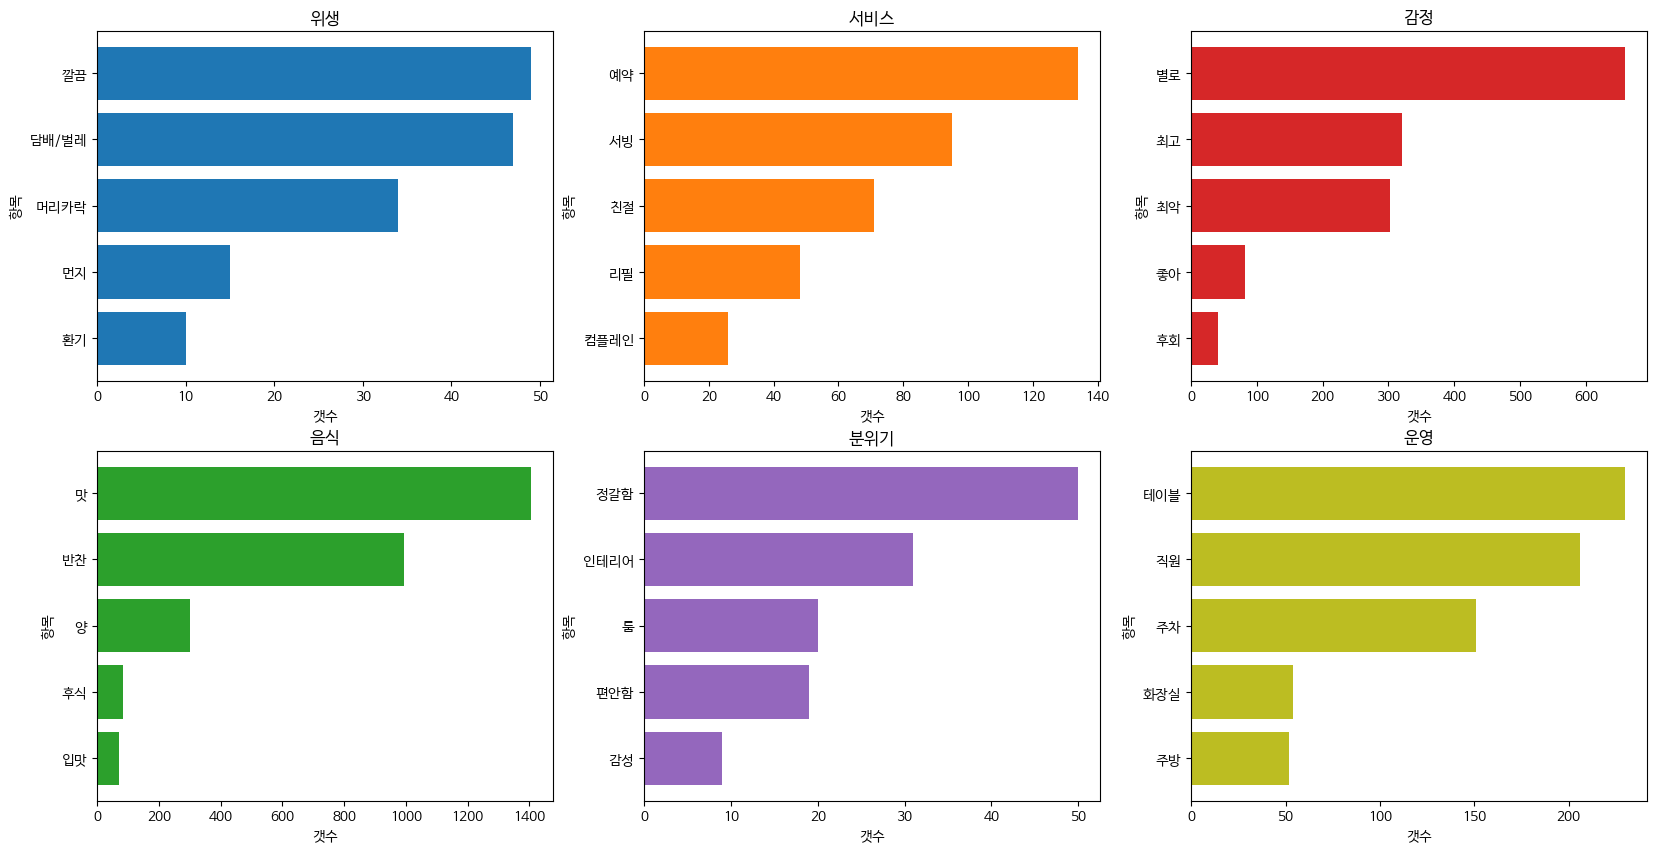

In [135]:
### 막대 그래프 생성
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))


# 위생 부문 시각화
count_clean1 = clean.count('담배') + clean.count('벌레')
count_clean2 = clean.count('먼지')
count_clean3 = clean.count('머리카락')
count_clean4 = clean.count('깔끔') + clean.count('청결')
count_clean5 = clean.count('환기')

categories = ['담배/벌레', '먼지', '머리카락', '깔끔', '환기']
counts = [count_clean1, count_clean2, count_clean3, count_clean4, count_clean5]
df_clean = pd.DataFrame({'indexs' : categories, 'val' : counts})
df_clean = df_clean.sort_values(by='val', ascending=True).reset_index(drop=True)

ax[0][0].barh(df_clean.indexs, df_clean.val,color= 'tab:blue')
ax[0][0].set_xlabel('갯수')
ax[0][0].set_ylabel('항목')
ax[0][0].set_title('위생')



# 서비스 부문 시각화
count_service1 = service.count('컴플레인') + service.count('클레임')
count_service2 = service.count('서빙')
count_service3 = service.count('예약')
count_service4 = service.count('친절')
count_service5 = service.count('리필')

categories = ['컴플레인', '서빙', '예약', '친절', '리필']
counts = [count_service1, count_service2, count_service3, count_service4, count_service5]
df_service = pd.DataFrame({'indexs' : categories, 'val' : counts})                          # 크기 순으로 정렬된 막대그래프를 그리기 위해서 추가
df_service = df_service.sort_values(by='val', ascending=True).reset_index(drop=True)        # 크기 순으로 정렬된 막대그래프를 그리기 위해서 추가

ax[0][1].barh(df_service.indexs, df_service.val, color='tab:orange')        # 크기 순으로 정렬된 막대그래프를 그리기 위해서 수정
ax[0][1].set_xlabel('갯수')
ax[0][1].set_ylabel('항목')
ax[0][1].set_title('서비스')




# 음식 부문 시각화
count_food1 = food.count('맛')
count_food2 = food.count('양')
count_food3 = food.count('입맛')
count_food4 = food.count('반찬') + food.count('반찬이') + food.count('반찬도') + food.count('밑반찬')
count_food5 = food.count('후식') + food.count('후식으로') + food.count('후식까지') + food.count('디저트') + food.count('디저트로') + food.count('디저트는') + food.count('디저트가')

categories = ['맛', '양', '입맛', '반찬', '후식']
counts = [count_food1, count_food2, count_food3, count_food4, count_food5]
df_food = pd.DataFrame({'indexs' : categories, 'val' : counts})
df_food = df_food.sort_values(by='val', ascending=True).reset_index(drop=True)

ax[1][0].barh(df_food.indexs, df_food.val,color='tab:green')
ax[1][0].set_xlabel('갯수')
ax[1][0].set_ylabel('항목')
ax[1][0].set_title('음식')
# 한정식 식당이다 보니 메인 요리 외에 반찬류에도 많은 평가가 있음을 볼 수 있다.



# 분위기 부문 시각화
count_vibe1 = vibe.count('인테리어')
count_vibe2 = vibe.count('감성')
count_vibe3 = vibe.count('편안한') + vibe.count('편안하게') + vibe.count('편안하고')    # '편안'이 들어가는 키워드 3개의 총 수 합치기
count_vibe4 = vibe.count('정갈한') + vibe.count('정갈하게') + vibe.count('정갈하고')    # '정갈'이 들어가는 키워드 3개의 총 수 합치기
count_vibe5 = vibe.count('룸')

categories = ['인테리어', '감성', '편안함', '정갈함', '룸']
counts = [count_vibe1, count_vibe2, count_vibe3, count_vibe4, count_vibe5]
df_vibe = pd.DataFrame({'indexs' : categories, 'val' : counts})                     # 크기 순으로 정렬된 막대그래프를 그리기 위해서 추가
df_vibe = df_vibe.sort_values(by='val', ascending=True).reset_index(drop=True)      # 크기 순으로 정렬된 막대그래프를 그리기 위해서 추가

ax[1][1].barh(df_vibe.indexs, df_vibe.val, color='tab:purple')           # 크기 순으로 정렬된 막대그래프를 그리기 위해서 수정
ax[1][1].set_xlabel('갯수')
ax[1][1].set_ylabel('항목')
ax[1][1].set_title('분위기')





# 감정 부문 시각화
count_emotion1 = emotion.count('최고')
count_emotion2 = emotion.count('최악')
count_emotion3 = emotion.count('좋아')
count_emotion4 = emotion.count('후회')
count_emotion5 = emotion.count('별로')

categories = ['최고', '최악', '좋아', '후회', '별로']
counts = [count_emotion1, count_emotion2, count_emotion3, count_emotion4, count_emotion5]
df_emotion = pd.DataFrame({'indexs' : categories, 'val' : counts})                     # 크기 순으로 정렬된 막대그래프를 그리기 위해서 추가
df_emotion = df_emotion.sort_values(by='val', ascending=True).reset_index(drop=True)      # 크기 순으로 정렬된 막대그래프를 그리기 위해서 추가

ax[0][2].barh(df_emotion.indexs, df_emotion.val, color='tab:red')           # 크기 순으로 정렬된 막대그래프를 그리기 위해서 수정
ax[0][2].set_xlabel('갯수')
ax[0][2].set_ylabel('항목')
ax[0][2].set_title('감정')




# 운영 부문 시각화
count_manage1 = manage.count('테이블')
count_manage2 = manage.count('직원')
count_manage3 = manage.count('화장실')
count_manage4 = manage.count('주방')
count_manage5 = manage.count('주차') + manage.count('주차장') + manage.count('주차공간')

categories = ['테이블', '직원', '화장실', '주방', '주차']
counts = [count_manage1, count_manage2, count_manage3, count_manage4, count_manage5]
df_manage = pd.DataFrame({'indexs' : categories, 'val' : counts})                     # 크기 순으로 정렬된 막대그래프를 그리기 위해서 추가
df_manage = df_manage.sort_values(by='val', ascending=True).reset_index(drop=True)      # 크기 순으로 정렬된 막대그래프를 그리기 위해서 추가

ax[1][2].barh(df_manage.indexs, df_manage.val, color='tab:olive')           # 크기 순으로 정렬된 막대그래프를 그리기 위해서 수정
ax[1][2].set_xlabel('갯수')
ax[1][2].set_ylabel('항목')
ax[1][2].set_title('운영')


plt.show()

# 기대효과

> 한식당의 항목별로 분석한 결과로 추출된 키워드를 활용하여 구글 서베이폼을 작성했습니다.  
해당 설문지는 실제로 식당을 운영중인 자영업자와, 자영업 중심 카페에 포스팅하여 응답을 받아보았습니다.

<img src="기대효과1.png" width="45%"/>
<img src="기대효과2.png" width="45%"/>
<img src="기대효과3.png" width="70%"/>